In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# EDA

Set a predetermined seed so all our results can be replicated

In [ ]:
RANDOM_SEED = 1337

Original data downloaded from: https://www.kaggle.com/datasets/abhinav89/telecom-customer?resource=download. <br />
Data can be cleaned by running clean_raw.py. <br/>

In [65]:
full_data = pd.read_csv('Dataset/clean_data.csv', index_col='Customer_ID')

- Data contains 100,000 rows and 99 features
- Customer_ID serves as the primary key for each customer 
- Target variable is 'churn' where
    -  1 = Customer Churned
    -  0 = Customer Stayed

In [ ]:
full_data.shape

(100000, 99)

In [10]:
full_data.head(5)

,actvsubs,adjmou,adjqty,adjrev,adults,area,asl_flag,attempt_mean,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,avgmou,avgqty,avgrev,blck_dat_mean,blck_vce_mean,callfwdv_mean,callwait_mean,cc_mou_mean,ccrndmou_mean,change_mou,change_rev,churn,comp_dat_mean,comp_vce_mean,complete_mean,crclscod,creditcd,custcare_mean,da_mean,datovr_mean,drop_blk_mean,drop_dat_mean,drop_vce_mean,dualband,dwllsize,dwlltype,eqpdays,ethnic,forgntvl,hhstatin,hnd_price,hnd_webcap,income,infobase,inonemin_mean,iwylis_vce_mean,kid0_2,kid11_15,kid16_17,kid3_5,kid6_10,lor,marital,models,months,mou_cdat_mean,mou_cvce_mean,mou_mean,mou_opkd_mean,mou_opkv_mean,mou_pead_mean,mou_peav_mean,mou_rvce_mean,mouiwylisv_mean,mouowylisv_mean,new_cell,numbcars,opk_dat_mean,opk_vce_mean,ovrmou_mean,ovrrev_mean,ownrent,owylis_vce_mean,peak_dat_mean,peak_vce_mean,phones,plcd_dat_mean,plcd_vce_mean,prizm_social_one,recv_sms_mean,recv_vce_mean,refurb_new,rev_mean,roam_mean,rv,threeway_mean,totcalls,totmou,totmrc_mean,totrev,truck,unan_dat_mean,unan_vce_mean,uniqsubs,vceovr_mean
Customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,136.0,322.0,38.0,-157.25,-18.9975,0.0,0.0,23.9975,0.00,0.0,22.500,219.25,0.2475,0.0,2.0,Y,2.0,361.0,0.0,149.98999,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,C,WCMB,NORTHWEST/ROCKY MOUNTAIN AREA,S,S,A,A,N,1,1602,1504.62,0.0,1.0,0.666667,45.000000,61,90.643333,42.333333,132.600000,0.0,0.0,0.0,0.000000,52.333333,0.0,3.0,0.0,116,0.0,0.666667,0.000000,0.000000,18.000000,0.000000,0.000000,30,4228.00000,15.0,0.000000,24.000000,83.37,97.176667,58.000000,1.333333,0.000000,45.000000,0.0,52.333333,55.220000,0.000000,0.0,32.69,4085.00,0.0,29.66,1453.44,0.0,1,272,1652,0.0,4.0,0.0,2,0.333333,0.0,6.333333,0.0
1000002,275.0,477.0,48.0,532.25,50.9875,9.1,0.0,57.4925,22.75,0.0,37.425,482.75,0.2475,9.1,6.0,N,7.0,240.0,0.0,149.98999,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,C,WC,CHICAGO AREA,S,U,A,EA,Z,1,14624,2851.68,0.0,1.0,1.000000,193.333333,56,189.396667,69.000000,75.333333,0.0,0.0,0.0,6.333333,263.333333,1.0,1.0,0.0,158,1.0,8.333333,46.333333,1.666667,53.000000,24.216667,0.333333,40,26400.00000,1.0,5.463333,157.000000,479.40,55.280000,83.666667,9.333333,3.696667,193.333333,0.0,263.333333,169.343333,6.333333,0.0,265.89,26367.00,0.0,51.53,2833.88,0.0,0,305,14654,0.0,5.0,0.0,1,5.666667,0.0,61.333333,0.0
1000003,6.0,11.0,17.0,-4.25,0.0000,0.0,0.0,16.9900,0.00,0.0,16.990,10.25,0.0000,0.0,1.0,N,2.0,1504.0,0.0,29.98999,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,C,NaN,GREAT LAKES AREA,M,S,A,C,N,1,7888,2155.91,0.0,2.0,0.000000,6.000000,58,5.426667,0.333333,5.193333,0.0,0.0,0.0,0.000000,9.000000,0.0,2.0,0.0,7,0.0,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,17,24385.05333,7.0,0.000000,1.000000,433.98,0.000000,5.000000,0.333333,0.000000,6.000000,0.0,9.000000,0.233333,0.000000,0.0,140.86,24303.05,0.0,34.54,1934.47,0.0,1,12,7903,0.0,5.0,0.0,1,0.000000,0.0,2.666667,0.0
1000004,25.0,50.0,40.0,-1.50,0.0000,0.0,0.0,38.0000,0.00,0.0,38.000,7.50,0.0000,0.0,1.0,N,1.0,1812.0,0.0,29.98999,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,1.0,C,NaN,CHICAGO AREA,M,T,D,B,U,1,1479,2000.90,0.0,4.0,0.000000,3.666667,60,8.410000,1.333333,3.380000,0.0,0.0,0.0,0.000000,3.666667,0.0,1.0,0.0,3,0.0,0.000000,0.333333,0.000000,1.333333,0.256667,0.000000,38,3065.00000,6.0,0.000000,3.666667,63.23,0.413333,1.333333,0.000000,0.000000,3.666667,0.0,3.666667,5.450000,0.000000,0.0,30.81,3035.00,0.0,40.45,1941.81,0.0,0,8,1502,0.0,6.0,0.0,1,0.000000,0.0,0.000000,0.0
1000005,196.0,586.0,80.0,38.50,0.0000,0.0,0.0,55.2300,0.00,0.0,71.980,570.50,0.0000,0.0,4.0,Y,6.0,434.0,0.0,149.98999,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,C,WCMB,NEW ENGLAND AREA,S,U,O,A,I,1,4452,2181.12,0.0,1.0,0.666667,137.000000,57,285.233333,94.666667,173.476667,0.0,0.0,0.0,15.000000,222.333333,0.0,1.0,0.0,191,0.0,9.666667,14.666667,8.666667,66.000000,10.816667,0.000000,55,14028.00000,5.0,11.076667,90.333333,249.38,106.330000,97.333333,10.333333,0.366667,137.000000,0.0,222.3

Our target variable in the data is surprisingly well balanced. 

<AxesSubplot:xlabel='churn', ylabel='count'>

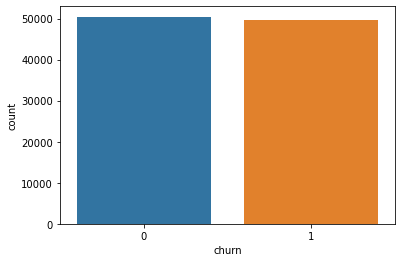

In [66]:
sns.countplot(x=full_data.churn)

In [98]:
miss_data_cols = full_data.columns[full_data.isna().sum()>0]
pct_miss_data = (
    full_data[miss_data_cols].isna().sum()
    .sort_values()
    /full_data.shape[0]
)

Text(0.5, 1.0, 'hi')

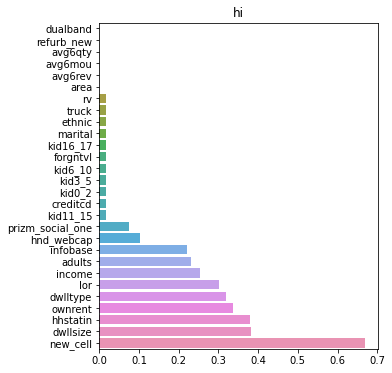

In [101]:
plt.figure(figsize=(5,6))
ax = sns.barplot(x=num_miss_data,y=num_miss_data.index)
ax.set_title('')